# Back Testing Statistics
Chapter 6 of the book: "Build Your Own AI Investor"

In [43]:
# Code from Book: Build Your Own AI Investor
# Damon Lee 2021
# Check out the performance on www.valueinvestingai.com
# Code uses data from the (presumably) nice people at https://simfin.com/. 
# Feel free to fork this code for others to see what can be done with it.

In [44]:
from platform import python_version
print(python_version())

3.7.10


In [45]:
import pandas as pd
import numpy as np
import math
import pickle # get the ML model from other notebook
from matplotlib import pyplot as plt # scatter plot
import matplotlib.lines as mlines # plot

In [46]:
# Set the plotting DPI settings to be a bit higher.
plt.rcParams['figure.figsize'] = [7.0, 4.5]
plt.rcParams['figure.dpi'] = 150

In [47]:
# X AND Y
# The backtester needs dates from the old y vector 
# to plot the stock prices.

# Financial ratios 
X=pd.read_csv("Annual_Stock_Price_Fundamentals_Ratios.csv", 
              index_col=0)

# Annual stock performances, with date data.
y_withData=pd.read_csv("Annual_Stock_Price_Performance_Filtered.csv", 
                       index_col=0)

# Convert to date
y_withData["Date"] = pd.to_datetime(y_withData["Date"])
y_withData["Date2"] = pd.to_datetime(y_withData["Date2"])

# X AND Y (splitting for train/test done previously for trained model)
X_train=pd.read_csv("Annual_Stock_Price_Fundamentals_Ratios_train.csv", 
                    index_col=0)
X_test=pd.read_csv("Annual_Stock_Price_Fundamentals_Ratios_test.csv", 
                   index_col=0)
y_train=pd.read_csv("Annual_Stock_Price_Performance_Percentage_train.csv", 
                    index_col=0)
y_test=pd.read_csv("Annual_Stock_Price_Performance_Percentage_test.csv", 
                   index_col=0)

# Get y_withData to correspond to y_test
y_withData_Test=pd.DataFrame()
y_withData_Test=y_withData.loc[y_test.index, :]

# Convert string to datetime
y_withData_Test["Date"] = pd.to_datetime(y_withData_Test["Date"])
y_withData_Test["Date2"] = pd.to_datetime(y_withData_Test["Date2"])

In [48]:
y_withData_Test.head()

,Ticker,Open Price,Date,Volume,Ticker2,Open Price2,Date2,Volume2
7217,INTC,12.89,2009-02-23,1.139689e+09,INTC,20.84,2010-02-23,1.297192e+09
12508,SIX,40.20,2014-02-20,5.493330e+07,SIX,47.62,2015-02-20,9.688984e+07
14996,WHR,139.06,2014-02-18,1.992591e+08,WHR,211.96,2015-02-18,1.579801e+08
5852,FUEL,2.35,2016-06-21,5.085330e+05,FUEL,2.71,2017-06-21,7.417731e+05
8857,MCHP,47.40,2014-05-30,4.534758e+07,MCHP,49.25,2015-06-01,7.098634e+07


In [49]:
y_withData.head()

,Ticker,Open Price,Date,Volume,Ticker2,Open Price2,Date2,Volume2
0,A,16.78,2008-12-19,248323864.0,A,29.60,2009-12-21,93198560.0
1,A,29.60,2009-12-21,93198560.0,A,40.65,2010-12-21,146961945.0
2,A,40.10,2010-12-20,161350370.0,A,33.99,2011-12-20,124797684.0
3,A,33.73,2011-12-16,105332044.0,A,39.98,2012-12-17,138114908.0
4,A,40.58,2012-12-20,154557046.0,A,57.47,2013-12-20,169766380.0


In [50]:
y_train

,Perf
3634,0.336401
4169,-0.463244
9033,0.208634
6658,0.079271
13270,0.319159
...,...
5191,0.220935
13418,-0.114247
5390,0.122841
860,-0.096197


# Functions
A little different from previous chapter code

In [51]:
def calcZScores(X):
    '''
    Calculate Altman Z'' scores 1995
    '''
    Z = pd.DataFrame()
    Z['Z score'] = 3.25 \
    + 6.51 * X['(CA-CL)/TA']\
    + 3.26 * X['RE/TA']\
    + 6.72 * X['EBIT/TA']\
    + 1.05 * X['Book Equity/TL']
    return Z

def getYRawData(directory='C:/Users/G50/Stock_Data/SimFin2021/'):
    '''
    Can set directory to look for file in.
    Get daily stock price time series for ALL stocks. 
    5M rows. Some days missing.
    Returns DataFrame
    '''
    daily_stock_prices=pd.read_csv(directory+'us-shareprices-daily.csv',
                                   delimiter=';')
    daily_stock_prices["Date"]=pd.to_datetime(daily_stock_prices["Date"])
    print('Reading historical time series stock data, matrix size is: ', 
          daily_stock_prices.shape)
    return daily_stock_prices

def getYPerf(y_):
    y=pd.DataFrame()
    y["Ticker"] = y_["Ticker"]
    y["Perf"]=(y_["Open Price2"]-y_["Open Price"])/y_["Open Price"]
    y[y["Perf"].isnull()]=0
    return y

def getStockPriceBetweenDates(date1, date2, ticker, d, rows):
    rows = d.loc[(d["Date"].values>date1) &\
                 (d["Date"].values<date2) &\
                 (d["Ticker"]==ticker)]
    return rows

def getStockPriceData(ticker, y_withData, mask, daily_stock_prices, rows):
    '''
    Get the stock price for a ticker
    between the buy/sell date (using y_withdata)
    '''
    date1 = y_withData[mask][y_withData[mask]["Ticker"] == ticker]["Date"].values[0]
    date2 = y_withData[mask][y_withData[mask]["Ticker"] == ticker]["Date2"].values[0]
    rows = getStockPriceBetweenDates(date1, date2,\
                                     ticker, daily_stock_prices, rows)
    return rows

def getDataForDateRange(date_Index_New, rows):
    '''
    Given a date range(index), and a series of rows,
    that may not correspond exactly,
    return a DataFrame that gets rows data,
    for each period in the date range(index)
    '''
    WeeklyStockDataRows = pd.DataFrame()
    for I in date_Index_New:
        WeeklyStockDataRows = WeeklyStockDataRows.append(\
          rows.iloc[rows.index.get_loc(I, method="nearest")])
    return WeeklyStockDataRows

def getStockTimeSeries(dateTimeIndex, y_withData, 
                       tickers, mask, daily_stock_prices):
    '''
    Get the stock price as a time series DataFrame
    for a list of tickers.
    A mask is used to only consider stocks for a certain period.
    dateTimeIndex is typically a weekly index,
    so we know what days to fetch the price for.
    '''
    stockRet = pd.DataFrame(index=dateTimeIndex)
    dTI_new = dateTimeIndex.strftime('%Y-%m-%d') # Change Date Format
    rows = pd.DataFrame()
    for tick in tickers:
        # Here "rows" is stock price time series data 
        # for individual stock
        rows = getStockPriceData(tick, 
                                 y_withData, 
                                 mask, 
                                 daily_stock_prices, 
                                 rows)
        rows.index = pd.DatetimeIndex(rows["Date"])
        WeeklyStockDataRows = getDataForDateRange(dTI_new,
                                                  rows)
        # Here can use Open, Close, Adj. Close, etc. price
        stockRet[tick] = WeeklyStockDataRows["Close"].values
    return stockRet

def getPortfolioRelativeTimeSeries(stockRet):
    '''
    Takes DataFrame of stock returns, one column per stock
    Normalises all the numbers so the price at the start is 1.
    Adds a column for the portfolio value.
    '''    
    for key in stockRet.keys():
        stockRet[key]=stockRet[key]/stockRet[key][0]
    stockRet["Portfolio"] = stockRet.sum(axis=1)/(stockRet.keys().shape[0])
    return stockRet

In [52]:
def getPortTimeSeriesForYear(date_starting, y_withData, X, 
                             daily_stock_prices, ml_model_pipeline):
    '''
    Function runs a backtest.
    Returns DataFrames of selected stocks/portfolio performance,
    for 1 year.
    y_withData is annual stock performances (all backtest years)
    date_starting e.g. '2010-01-01'
    daily_stock_prices is daily(mostly) stock price time series for
    all stocks
    '''
    
    # get y dataframe with ticker performance only
    y = getYPerf(y_withData)
    
    # Get performance only for time frame we care about,
    # mask original data using the start date
    thisYearMask = y_withData["Date"].between(\
              pd.to_datetime(date_starting) - pd.Timedelta(days=60),\
              pd.to_datetime(date_starting) + pd.Timedelta(days=60) )
    
    # Get return prediction from model
    y_pred = ml_model_pipeline.predict(X[thisYearMask])
    
    # Make it a DataFrame to select the top picks
    y_pred = pd.DataFrame(y_pred)
    
    ##### Change in code for Z score filtering ##### 
    # Separate out stocks with low Z scores
    z = calcZScores(X)
    
    # 3.75 is approx. B- rating
    bl_safeStocks=(z['Z score'][thisYearMask].reset_index(drop=True)>2) 
    y_pred_z = y_pred[bl_safeStocks]
    
    # Get bool list of top stocks
    bl_bestStocks=(
        y_pred_z[0]>y_pred_z.nlargest(8,0).tail(1)[0].values[0]) 
    
    dateTimeIndex = pd.date_range(\
                          start=date_starting, periods=52, freq='W')
    
    # 7 greatest performance stocks of y_pred 
    ticker_list = \
    y[thisYearMask].reset_index(drop=True)\
                      [bl_bestStocks&bl_safeStocks]["Ticker"].values
    ##### Change in code for Z score filtering ##### 
    
    # After we know our stock picks, we get the stock performance
    # Get DataFrame index of time stamp, series of stock prices, 
    # keys=tickers
    stockRet = getStockTimeSeries(dateTimeIndex, y_withData,
                                  ticker_list, thisYearMask, 
                                  daily_stock_prices)
    
    # Get DataFrame of relative stock prices from 1st day(or close) 
    # and whole portfolio
    stockRetRel = getPortfolioRelativeTimeSeries(stockRet)
    return [stockRetRel, stockRetRel["Portfolio"], ticker_list]

def getPortTimeSeries(y_withData, X, daily_stock_prices, ml_model_pipeline, verbose=True):
    '''
    Returns DataFrames of selected stocks/portfolio performance since 2009.
    Needs X and y(with data), the daily_stock_prices DataFrame,
    the model pipeline we want to test.
    X is standard X for model input.
    y_withData is the stock price before/after df with date information.
    Input X and y must be data that the model was not trained on.
    '''
    # set date range to make stock picks over
    dr=pd.date_range(start='2009-01-01', periods=11, freq='Y') 
    
    # For each date in the date_range, make stock selections
    # and plot the return results of those stock selections
    port_perf_all_years = pd.DataFrame()
    perfRef=1 # performance starts at 1.
    for curr_date in dr:
        
        [comp, this_year_perf, ticker_list] = \
        getPortTimeSeriesForYear(curr_date, y_withData, X,\
                                 daily_stock_prices, ml_model_pipeline)
        
        if verbose: # If you want text output
            print("Backtest performance for year starting ",\
                  curr_date, " is:",\
                  round((this_year_perf.iloc[-1]-1)*100,2), "%")
            print("With stocks:", ticker_list)
            for tick in ticker_list:
                print(tick, "Performance was:",\
                      round((comp[tick].iloc[-1]-1)*100,2), "%" )
            print("---------------------------------------------")
        
        # Stitch performance for every year together
        this_year_perf = this_year_perf * perfRef
        #print(comp)
        
        port_perf_all_years = pd.concat([port_perf_all_years,\
                                         this_year_perf])
        
        perfRef = this_year_perf.iloc[-1]
    
    # Return portfolio performance for all years
    port_perf_all_years.columns = ["Indexed Performance"]
    return port_perf_all_years

# Try out a single backtest

In [53]:
# backtest data
daily_stock_prices=getYRawData()

Reading historical time series stock data, matrix size is:  (6552275, 11)


In [13]:
#pl_linear.p, pl_ElasticNet.p, pl_KNeighbors.p, pl_rfregressor.p, pl_decTree.p, pl_svm.p
#pl_linear = pickle.load(open("pl_linear.p", "rb" ))
pl_linear = pickle.load(open("rfregressor.p", "rb" ))
test = getPortTimeSeries(y_withData_Test, X_test,
                         daily_stock_prices,
                         pl_linear)
print('Performance is: ', 100 * (test["Indexed Performance"][-1]-1), '%')

Backtest performance for year starting  2009-12-31 00:00:00  is: 63.89 %
With stocks: ['NFLX' 'TRN' 'GT' 'ARRS' 'ALGN' 'LVS' 'ANDV']
NFLX Performance was: 179.87 %
TRN Performance was: 49.44 %
GT Performance was: -10.48 %
ARRS Performance was: 6.66 %
ALGN Performance was: 7.14 %
LVS Performance was: 166.86 %
ANDV Performance was: 47.75 %
---------------------------------------------
Backtest performance for year starting  2010-12-31 00:00:00  is: -11.73 %
With stocks: ['INTL' 'BXC' 'WCG' 'PACB' 'GT' 'CDNS' 'CIE']
INTL Performance was: 2.84 %
BXC Performance was: -60.27 %
WCG Performance was: 47.96 %
PACB Performance was: -83.1 %
GT Performance was: -0.98 %
CDNS Performance was: 5.16 %
CIE Performance was: 6.32 %
---------------------------------------------
Backtest performance for year starting  2011-12-31 00:00:00  is: 10.77 %
With stocks: ['GRPN' 'REGN' 'VAC' 'ALKS' 'HEI' 'KATE' 'MTOR']
GRPN Performance was: -77.98 %
REGN Performance was: 73.75 %
VAC Performance was: 101.35 %
ALKS P

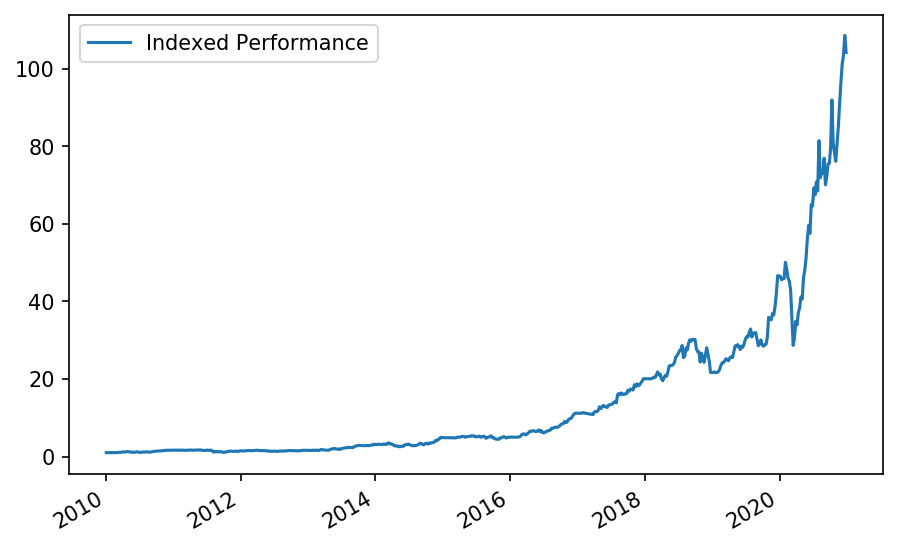

In [27]:
test.plot()

# Now loop through model tests and get some statistics to work with.

In [54]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
import pickle

In [55]:
# Linear model pipeline
def trainLinearModel(X_train, y_train):
    pl_linear = Pipeline([('Power Transformer', PowerTransformer()),
        ('linear', LinearRegression())])
    pl_linear.fit(X_train, y_train)
    return pl_linear

# ElasticNet model pipeline
def trainElasticNetModel(X_train, y_train):
    pl_ElasticNet = Pipeline([('Power Transformer', PowerTransformer()),
        ('ElasticNet', ElasticNet(l1_ratio=0.00001))])
    pl_ElasticNet.fit(X_train, y_train)
    return pl_ElasticNet

# KNeighbors regressor
def trainKNeighborsModel(X_train, y_train):
    pl_KNeighbors = Pipeline([('Power Transformer', PowerTransformer()),
        ('KNeighborsRegressor', KNeighborsRegressor(n_neighbors=40))])
    pl_KNeighbors.fit(X_train, y_train)
    return pl_KNeighbors

# DecisionTreeRegressor
def traindecTreeModel(X_train, y_train):
    pl_decTree = Pipeline([
        ('DecisionTreeRegressor',\
         DecisionTreeRegressor(max_depth=20, random_state=42))
    ])
    pl_decTree.fit(X_train, y_train)
    return pl_decTree

# RandomForestRegressor
def trainrfregressorModel(X_train, y_train):
    pl_rfregressor = Pipeline([
        ('RandomForestRegressor',\
         RandomForestRegressor(max_depth=10, random_state=42))
    ])
    pl_rfregressor.fit(X_train, y_train)
    
    return pl_rfregressor

# GradientBoostingRegressor
def traingbregressorModel(X_train, y_train):
    pl_GradBregressor = Pipeline([
        ('GradBoostRegressor',\
         GradientBoostingRegressor(n_estimators=100,\
                                   learning_rate=0.1,\
                                   max_depth=10,\
                                   random_state=42,\
                                   loss='ls'))  ])
    pl_GradBregressor.fit(X_train, y_train)
    
    return pl_GradBregressor

# SVM
def trainsvmModel(X_train, y_train):
    pl_svm = Pipeline([('Power Transformer', PowerTransformer()),
        ('SVR', SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1))])
    pl_svm.fit(X_train, y_train)
    return pl_svm

## Try and find a good train/test split proportion (rough)

In [56]:
# Y percentage perf
y_pec=pd.read_csv("Annual_Stock_Price_Performance_Percentage.csv", index_col=0)["Perf"]

In [56]:
model_pipeline_list = ['pl_linear', 'pl_KNeighbors', 'pl_decTree',\
                       'pl_GradBregressor', 'pl_rfregressor', 'pl_svm']

for model in model_pipeline_list:
    for myTstSze in [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]:
        X_train,X_test,y_train,y_test=train_test_split(X, y_pec,
                                                       test_size=myTstSze)
        
        if (model =='pl_ElasticNet'):
            model_pl = trainElasticNetModel(X_train, y_train)
        if (model =='pl_KNeighbors'):
            model_pl = trainKNeighborsModel(X_train, y_train)
        if (model =='pl_decTree'):
            model_pl = traindecTreeModel(X_train, y_train)
        if (model =='pl_rfregressor'):
            model_pl = trainrfregressorModel(X_train, y_train)
        if (model =='pl_GradBregressor'):
            model_pl = traingbregressorModel(X_train, y_train)
        if (model =='pl_svm'):
            model_pl = trainsvmModel(X_train, y_train)
        else:
            # Linear model default
            model_pl = trainLinearModel(X_train, y_train) 
            
        y_withData_Test=y_withData.loc[X_test.index]
        
        # Here is our backtesting code
        test = getPortTimeSeries(y_withData_Test, X_test,
                                 daily_stock_prices, 
                                 model_pl,
                                 verbose=False) 
        
        perf = test['Indexed Performance'][-1]
        vol = test['Indexed Performance'].diff().std()*np.sqrt(52)
        print('Performance:', round(perf, 2), 
              'Volatility:', round(vol,2),
              'Model', model, 'Test size: ', myTstSze)

Performance: 4.69 Volatility: 0.6 Model pl_linear Test size:  0.02
Performance: 5.08 Volatility: 0.8 Model pl_linear Test size:  0.1
Performance: 2.55 Volatility: 0.42 Model pl_linear Test size:  0.25
Performance: 1.36 Volatility: 0.29 Model pl_linear Test size:  0.5
Performance: 3.69 Volatility: 0.57 Model pl_linear Test size:  0.75
Performance: 4.69 Volatility: 0.73 Model pl_linear Test size:  0.9
Performance: 9.1 Volatility: 1.29 Model pl_linear Test size:  0.98
Performance: 2.5 Volatility: 0.37 Model pl_KNeighbors Test size:  0.02
Performance: 2.09 Volatility: 0.43 Model pl_KNeighbors Test size:  0.1
Performance: 2.48 Volatility: 0.37 Model pl_KNeighbors Test size:  0.25
Performance: 3.06 Volatility: 0.62 Model pl_KNeighbors Test size:  0.5
Performance: 2.93 Volatility: 0.77 Model pl_KNeighbors Test size:  0.75
Performance: 2.13 Volatility: 0.26 Model pl_KNeighbors Test size:  0.9
Performance: 3.75 Volatility: 0.68 Model pl_KNeighbors Test size:  0.98
Performance: 5.99 Volatility: 

## Now getting the backtesting statistics proper
Can run in parallel, takes awhile.

In [33]:
def getResultsForModel(model_pipeline_list, runs_per_model=1, verbose=True):
    '''
    getResultsForModel
    Choose the model pipelines to run loop for.
    '''
    i, results = 0, []
    for model in model_pipeline_list:
        for test_num in range(0, runs_per_model):
            X_train,X_test,y_train,y_test=train_test_split(X, y_pec,
                                                           test_size=0.5
                                                          )
            #Train different models
            if (model =='pl_linear'):
                model_pl = trainLinearModel(X_train, y_train)
            if (model =='pl_ElasticNet'):
                model_pl = trainElasticNetModel(X_train, y_train)
            if (model =='pl_KNeighbors'):
                model_pl = trainKNeighborsModel(X_train, y_train)
            if (model =='pl_rfregressor'):
                model_pl = trainrfregressorModel(X_train, y_train)
            if (model =='pl_decTree'):
                model_pl = traindecTreeModel(X_train, y_train)
            if (model =='pl_GradBregressor'):
                model_pl = traingbregressorModel(X_train, y_train)
            if (model =='pl_svm'):
                model_pl = trainsvmModel(X_train, y_train)
            y_withData_Test=y_withData.loc[X_test.index]

            # Here is our backtesting code
            test = getPortTimeSeries(y_withData_Test, X_test,
                                 daily_stock_prices, model_pl, 
                                     verbose=False) 
            
            perf = test['Indexed Performance'][-1]
            vol = test['Indexed Performance'].diff().std()*np.sqrt(52)
            if verbose:
                print('Performed test ',i , [i, model, perf, vol])
            results.append([i, model, perf, vol])
            i=i+1

    # Save our results for plotting
    results_df = pd.DataFrame(results, columns=["Test Number",\
                                                "Model Used",\
                                                "Indexed Return",\
                                                "Annual Volatility"])

    # Append to an existing results file if available, 
    # else make new results file.
    # In parallel there is an extremely remote chance 
    # two cores try and access file at same time. 
    # To keep code simple this is OK.
    import os
    if os.path.isfile("Backtest_statistics.csv"):
        results_df.to_csv("Backtest_statistics.csv", 
                          mode='a', 
                          header=False)
    else:
        results_df.to_csv("Backtest_statistics.csv")

In [37]:
# Run with 1 core
#model_pipeline_list = ['pl_KNeighbors']
model_pipeline_list = ['pl_rfregressor', 
                       'pl_decTree', 
                       'pl_svm', 
                       'pl_linear', 
                       'pl_GradBregressor', 
                       'pl_KNeighbors', 
                       'pl_ElasticNet']
model_pipeline_list = ['pl_GradBregressor']
getResultsForModel(model_pipeline_list, 100)

Performed test  0 [0, 'pl_GradBregressor', 4.618608681336333, 0.698614428147651]
Performed test  1 [1, 'pl_GradBregressor', 2.0055113222585086, 0.36781628791467696]
Performed test  2 [2, 'pl_GradBregressor', 8.2580578495017, 1.1961964808652146]
Performed test  3 [3, 'pl_GradBregressor', 1.2271374997273512, 0.3328030622824788]
Performed test  4 [4, 'pl_GradBregressor', 2.2674695843470363, 0.5863152407239495]
Performed test  5 [5, 'pl_GradBregressor', 3.271333766383886, 0.503209222791356]
Performed test  6 [6, 'pl_GradBregressor', 2.720094329516391, 0.6873444414616845]
Performed test  7 [7, 'pl_GradBregressor', 14.350279552848814, 2.3144471032385576]
Performed test  8 [8, 'pl_GradBregressor', 3.66503648574882, 0.7712708915651183]
Performed test  9 [9, 'pl_GradBregressor', 1.9046358991205334, 0.356443376895695]
Performed test  10 [10, 'pl_GradBregressor', 4.207773753078165, 0.7440572970927183]
Performed test  11 [11, 'pl_GradBregressor', 3.0594710559398175, 0.5787961691234998]
Performed t

Performed test  98 [98, 'pl_GradBregressor', 2.371564768595354, 0.5395580319337705]
Performed test  99 [99, 'pl_GradBregressor', 2.7100135709255233, 0.3905299110255597]


In [239]:
#Run in Parallel
# Specific models on each core
# Can run this many times, will just keep appending to results file.
model_pipeline_list_list = [['pl_GradBregressor', 'pl_ElasticNet'],
                            ['pl_decTree', 'pl_rfregressor'],
                            ['pl_svm'],
                            ['pl_linear', 'pl_KNeighbors']]

import threading
l = len(model_pipeline_list_list)

thread_list = []
for i in range(l):
    thread = threading.Thread(target=getResultsForModel, args=(model_pipeline_list_list[i], 50, False))
    thread_list.append(thread)
    thread.start()
    print('Thread '+str(i)+' started.')

Thread 0 started.
Thread 1 started.
Thread 2 started.
Thread 3 started.


In [250]:
# Can check if threads are still running any time.
# Notebook will look as though nothing is running
# But things are running in background.
for i in thread_list:
    print(i.is_alive())

False
False
False
False


# Investigating Backtest Statistics

In [38]:
results_df = pd.read_csv('Backtest_statistics.csv', index_col=0)
results_df.reset_index(inplace=True, drop=True)

In [39]:
results_df

,Test Number,Model Used,Indexed Return,Annual Volatility
0,0,pl_svm,4.342707,0.538604
1,1,pl_svm,2.461412,0.526777
2,2,pl_svm,5.925975,0.777033
3,0,pl_linear,2.471625,0.386029
4,1,pl_linear,5.842067,0.743603
...,...,...,...,...
5738,95,pl_ElasticNet,2.853732,0.740167
5739,96,pl_ElasticNet,3.665904,0.533378
5740,97,pl_ElasticNet,5.519068,0.731825
5741,98,pl_ElasticNet,2.139453,0.418671


In [40]:
def plotBacktestDist(results_df, model_file, col):
    ax=results_df[results_df['Model Used']==model_file][col].hist(\
                                    bins=50, density=True, alpha=0.7)
    
    ax2=results_df[results_df['Model Used']==model_file][col].plot.kde(\
                                    alpha=0.9)
    
    max_val=results_df[results_df['Model Used']==model_file][col].max()
    ax.set_xlabel(col)
    ax.set_ylabel('Normalised Frequency')
    ax.set_title('{} Backtest Distribution for {}, {} Runs'.format(\
          col,\
          model_file,\
          results_df[results_df['Model Used']==model_file][col].size))
    ax.grid()
    mean=results_df[results_df['Model Used']==model_file][col].mean()
    ymin, ymax = ax.get_ylim()
    
    if (col=='Indexed Return'): 
        # Plot S&P 500 returns
        # begin 2010 -> end 2020
        ax.plot([3.511822, 3.511822], [ymin, ymax],\
                color='r', linestyle='-', linewidth=1.5, alpha=1)
        ax.plot([mean, mean], [ymin, ymax],\
                color='lime', linestyle='--', linewidth=1.5, alpha=1)
        plt.xlim(0, 10)
    
    if (col=='Annual Volatility'): 
        # Plot S&P 500 volatility
        # begin 2010 -> end 2020
        ax.plot([0.325059094152396, 0.325059094152396], [ymin, ymax],\
                color='r', linestyle='-', linewidth=2)  
        ax.plot([mean, mean], [ymin, ymax],\
                color='lime', linestyle='--', linewidth=2)  
        plt.xlim(0, 1.5)
    ax.legend(['Fitted Smooth Kernel','S&P500 Benchmark', \
               'Simulation Mean {}'.format(round(mean,2)),\
               'Simulation Backtests'])

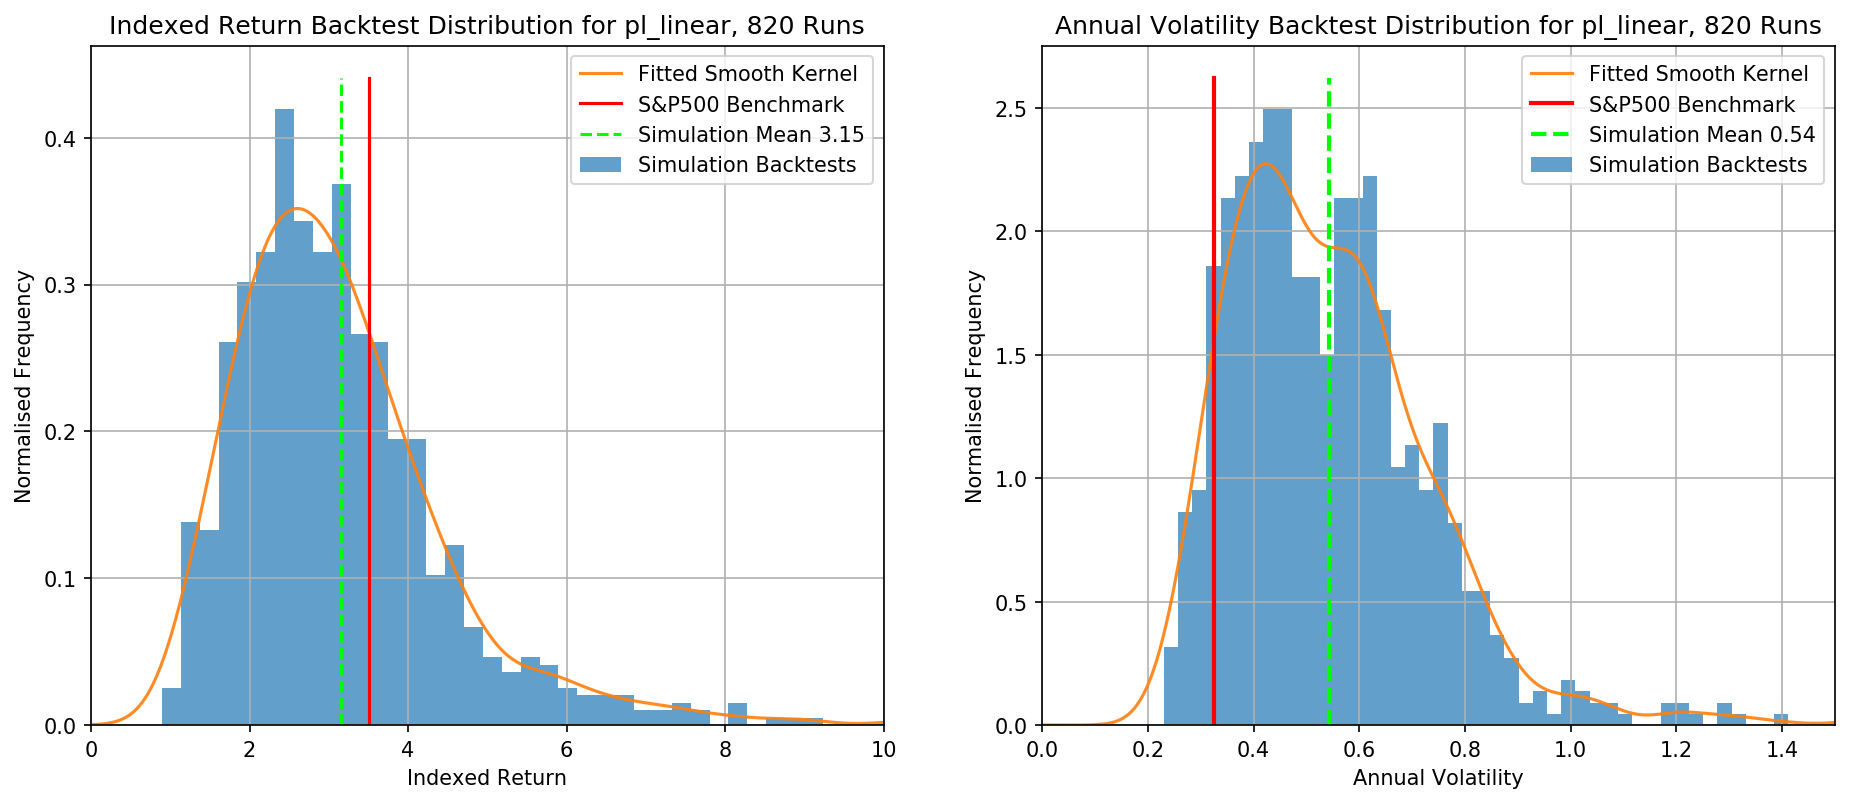

In [44]:
model_file = 'pl_linear'#['pl_linear', 'pl_ElasticNet', 'pl_rfregressor', 'pl_decTree', 'pl_svm', 'pl_KNeighbors']
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plotBacktestDist(results_df, model_file, 'Indexed Return')
plt.subplot(1,2,2)
plotBacktestDist(results_df, model_file, 'Annual Volatility')

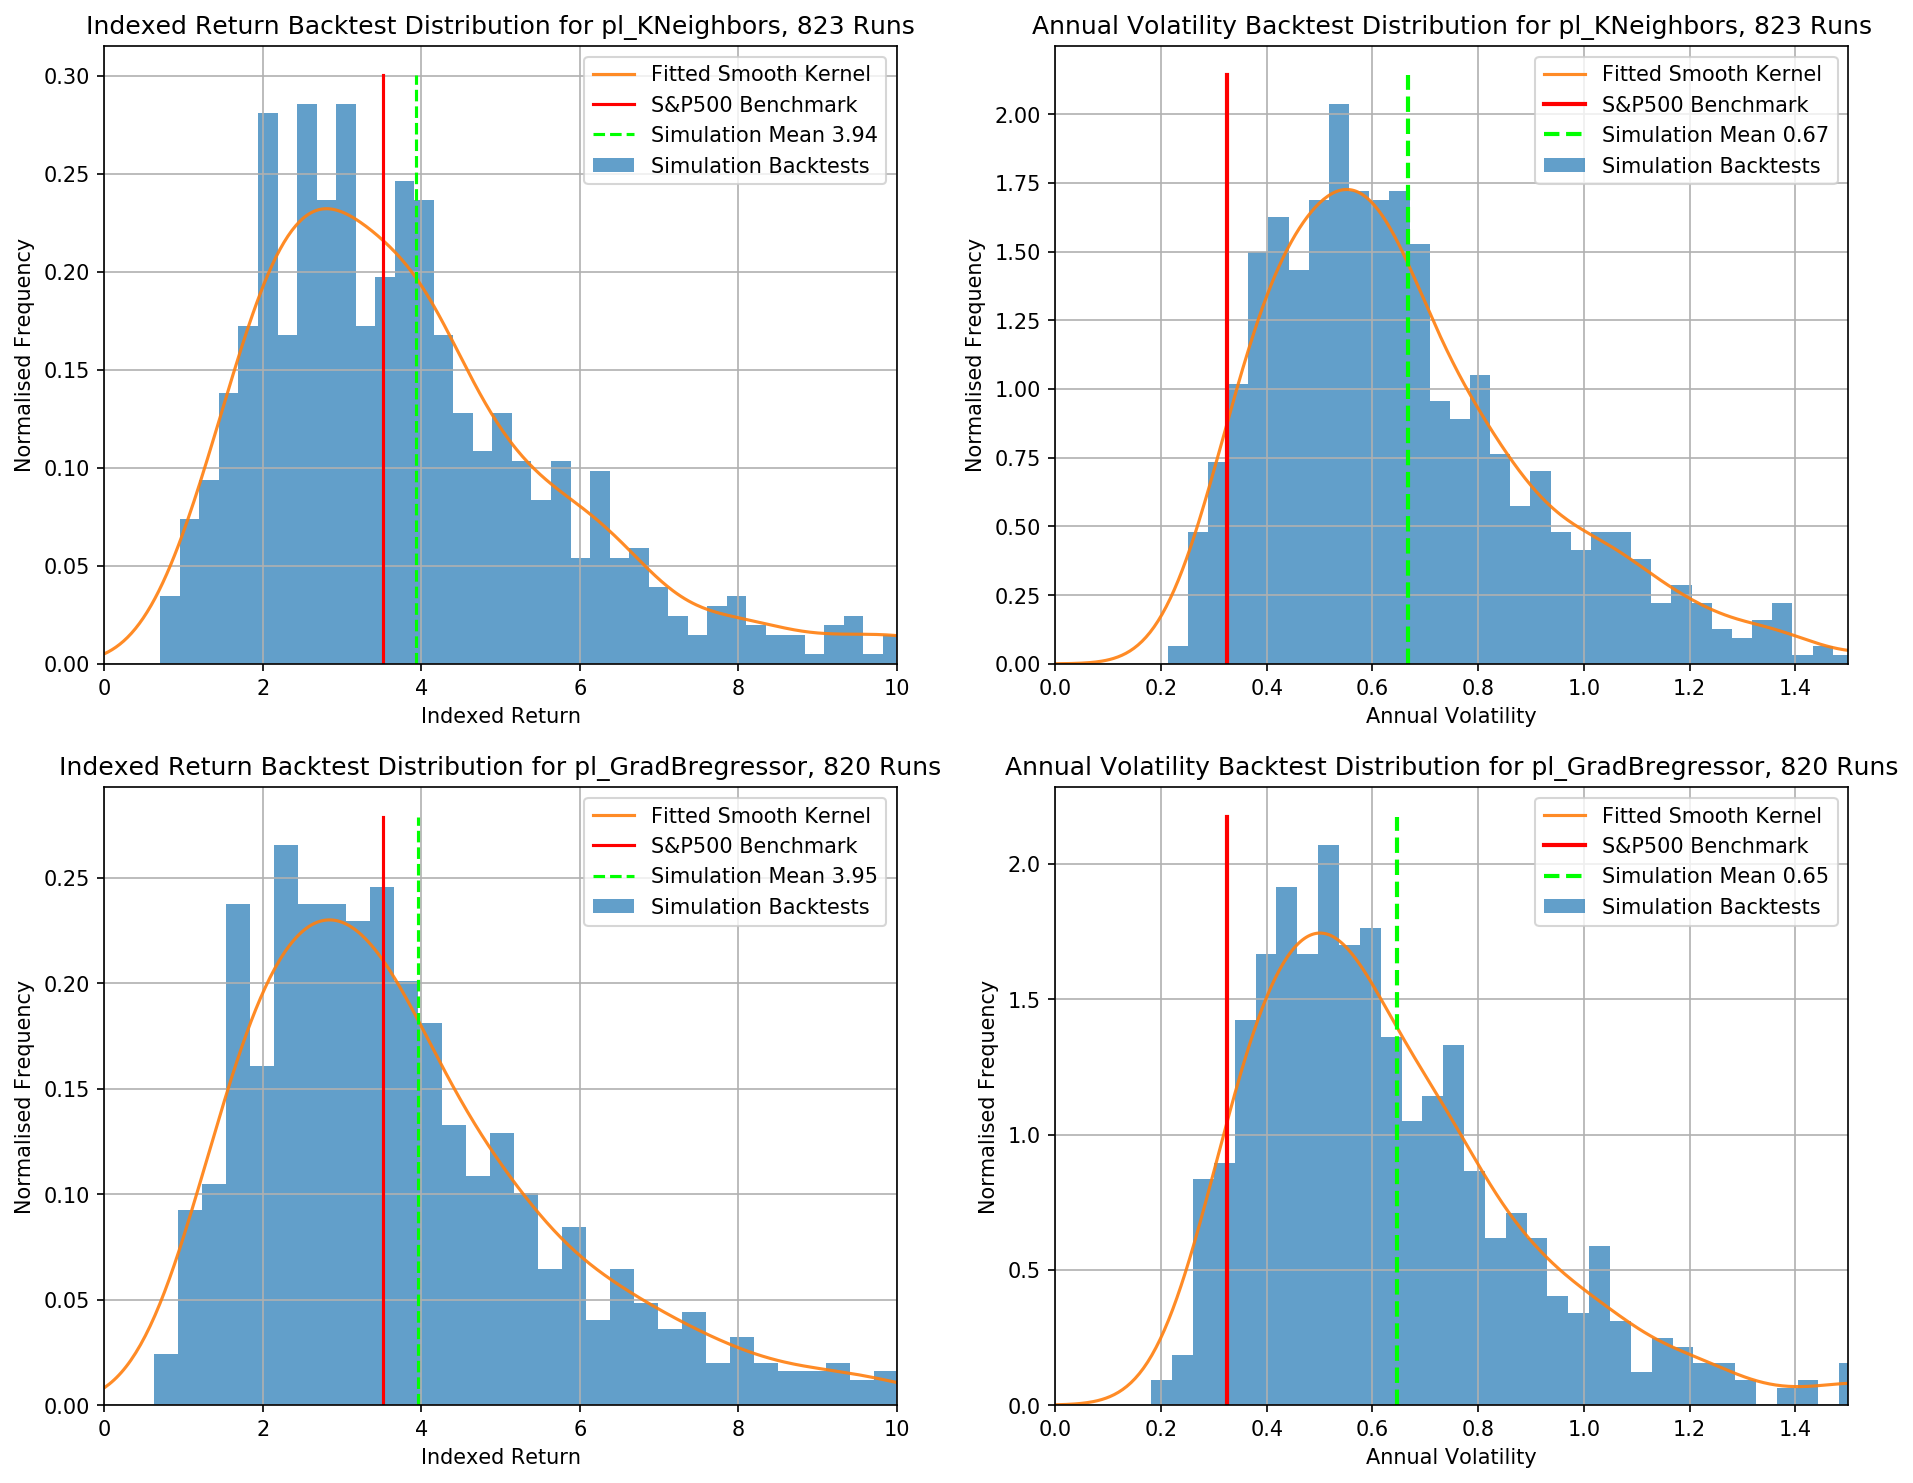

In [46]:
#model_file = ['pl_ElasticNet','pl_decTree', 'pl_rfregressor', 'pl_svm', 'pl_KNeighbors', 'pl_GradBregressor']
#model_file = ['pl_linear', 'pl_ElasticNet']
#model_file = ['pl_decTree', 'pl_rfregressor', 'pl_svm']
model_file = ['pl_KNeighbors', 'pl_GradBregressor']
#model_file = ['pl_rfregressor']
numPlots = len(model_file)
plt.figure(figsize=(15,6*numPlots))
for I in range(0, numPlots):
    plt.subplot(numPlots,2,I*2+1)
    plotBacktestDist(results_df, model_file[I], 'Indexed Return')
    plt.subplot(numPlots,2,I*2+2)
    plotBacktestDist(results_df, model_file[I], 'Annual Volatility')

# Chosen Regressors for AI are GradBoost and KNN

We will expect more volatility.

Text(0.5, 1.0, 'KNN Backtest Return vs. Volatility')

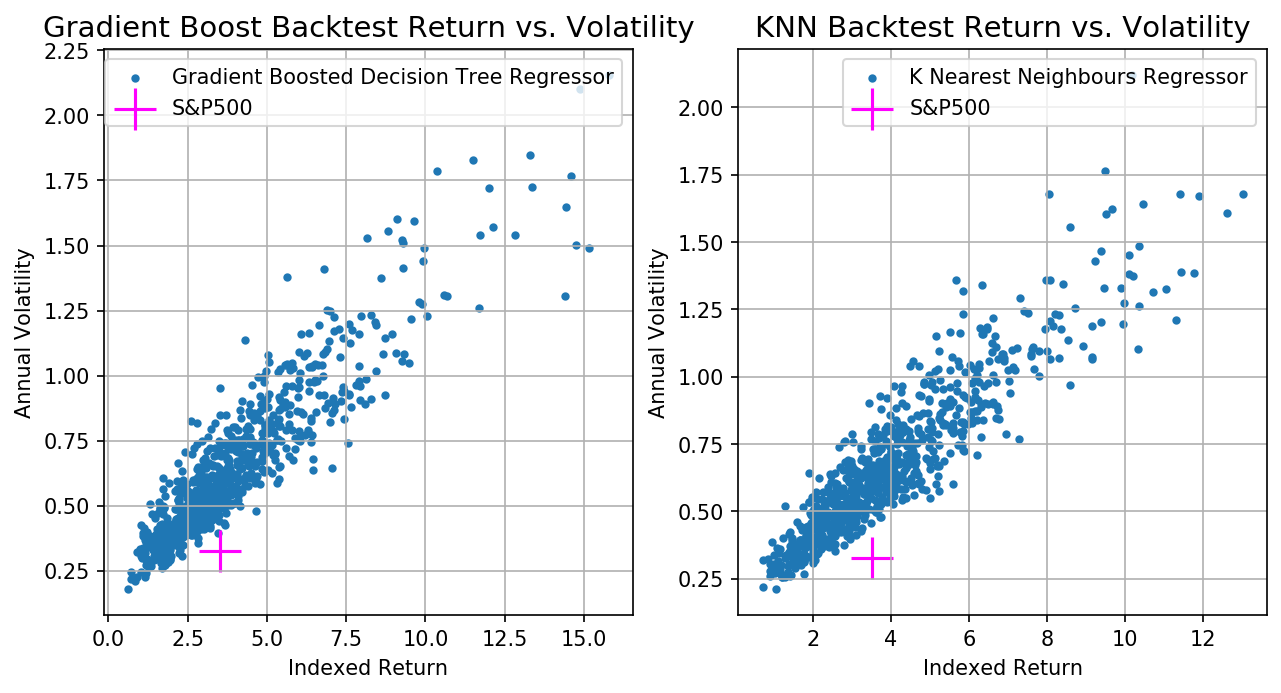

In [47]:
# GRAPH OF RETURN VS VOLATILITY
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
returns = results_df[results_df['Model Used']=='pl_GradBregressor']['Indexed Return']
vols = results_df[results_df['Model Used']=='pl_GradBregressor']['Annual Volatility']
plt.scatter(returns, vols, marker='.')
plt.scatter(3.511822, 0.325059094152396, marker='+', color='fuchsia', s=400)
plt.xlabel('Indexed Return')
plt.ylabel('Annual Volatility')
plt.grid()
plt.legend(['Gradient Boosted Decision Tree Regressor', 'S&P500'])
plt.title('Gradient Boost Backtest Return vs. Volatility', fontsize=14)

plt.subplot(1,2,2)
returns = results_df[results_df['Model Used']=='pl_KNeighbors']['Indexed Return']
vols = results_df[results_df['Model Used']=='pl_KNeighbors']['Annual Volatility']
plt.scatter(returns, vols, marker='.')
plt.scatter(3.511822, 0.325059094152396, marker='+', color='fuchsia', s=400)
plt.xlabel('Indexed Return')
plt.ylabel('Annual Volatility')
plt.grid()
plt.legend(['K Nearest Neighbours Regressor', 'S&P500'])
plt.title('KNN Backtest Return vs. Volatility', fontsize=14)

Text(0.5, 0, 'Annual Volatility')

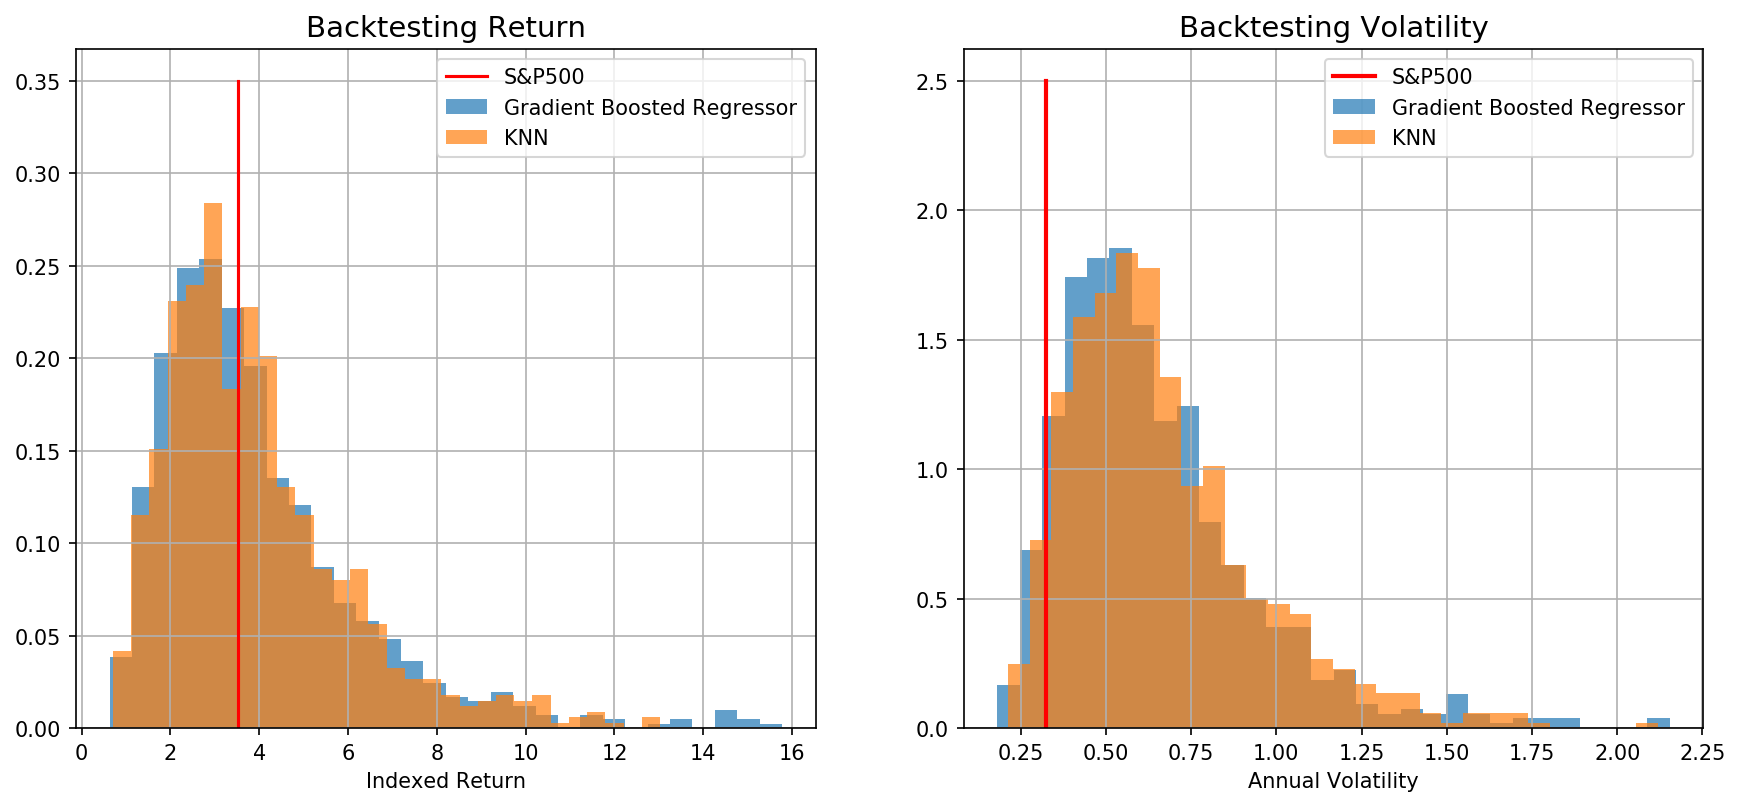

In [48]:
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
results_df[results_df['Model Used']=='pl_GradBregressor']['Indexed Return'].hist(bins=30,\
                                                density=True, alpha=0.7)
results_df[results_df['Model Used']=='pl_KNeighbors']['Indexed Return'].hist(bins=30,\
                                                density=True, alpha=0.7)
plt.plot([3.511822, 3.511822], [0, 0.35],\
                 color='r', linestyle='-', linewidth=1.5, alpha=1)
plt.legend(['S&P500','Gradient Boosted Regressor', 'KNN'])
plt.title('Backtesting Return', fontsize=14)
plt.xlabel('Indexed Return')

plt.subplot(1,2,2)
results_df[results_df['Model Used']=='pl_GradBregressor']['Annual Volatility'].hist(bins=30,\
                                                density=True, alpha=0.7)
results_df[results_df['Model Used']=='pl_KNeighbors']['Annual Volatility'].hist(bins=30,\
                                                density=True, alpha=0.7)
plt.plot([0.325059094152396, 0.325059094152396], [0, 2.5],\
                color='r', linestyle='-', linewidth=2)  
plt.legend(['S&P500','Gradient Boosted Regressor', 'KNN'])
plt.title('Backtesting Volatility', fontsize=14)
plt.xlabel('Annual Volatility')

# Figure out what the actual performance should be

In [111]:
# Choose the model pipelines to run loop for
model_pipeline_list = ['pl_GradBregressor', 'pl_KNeighbors']
tests_per_model=20

# Reduce test size and check performance to try and see a trend
# Is effectively *0.5 as test size is 1/2 of total data.
#test_size_modifier_list = [0.8, 0.6, 0.4, 0.2, 0.1, 0.05 ]
test_size_modifier_list = [0.05, 0.075]

# Results DataFrame
results_df2 = pd.DataFrame( columns=["Test Number",
                                            "Model Used",\
                                            "Test Set Size",\
                                            "Indexed Return",\
                                            "Annual Volatility"])

i, results = 0, []
for model in model_pipeline_list:
    for test_size_mod in test_size_modifier_list:
        for test_num in range(0, tests_per_model):
            
            X_train, X_test, y_train, y_test = \
            train_test_split(X, y_pec, test_size=0.5)
            
            new_test_size = round(len(X_test)//(1/test_size_mod))
            
            X_test, y_test = \
            X_test[:new_test_size], y_test[:new_test_size]
            
            if (model =='pl_KNeighbors'):
                model_pl = trainKNeighborsModel(X_train, y_train)
            if (model =='pl_GradBregressor'):
                model_pl = traingbregressorModel(X_train, y_train)
            y_withData_Test=y_withData.loc[X_test.index]

            # Here is our backtesting code
            test = getPortTimeSeries(y_withData_Test, X_test,
                     daily_stock_prices, model_pl, 
                         verbose=False) 
            
            perf = test['Indexed Performance'][-1]
            
            vol = test['Indexed Performance'].diff().std()*np.sqrt(52)
            
            #print('Performed test ',i , [i, model, new_test_size, perf, vol])     
            
            results_df2=results_df2.append(\
                        pd.DataFrame(\
                             [[i, model, new_test_size, perf, vol]],\
                                     columns=results_df2.keys()))      
            i=i+1
            
        print('For {} test size {}, Performance: {}, Vol: {}.'.format(\
              model, new_test_size, \
            results_df2['Indexed Return'].tail(tests_per_model).mean(),\
            results_df2['Annual Volatility'].tail(tests_per_model).mean()))

# Save our results for plotting
results_df2.to_csv("Backtest_statistics_Modified_test_size.csv")

For pl_GradBregressor test size 389, Performance: 3.429326030593308, Vol: 0.4879855935279528.
For pl_GradBregressor test size 584, Performance: 3.420117982432879, Vol: 0.4772889911691413.
For pl_KNeighbors test size 389, Performance: 2.8474486347372796, Vol: 0.4414147876713498.
For pl_KNeighbors test size 584, Performance: 3.308133097819644, Vol: 0.4909097815132636.


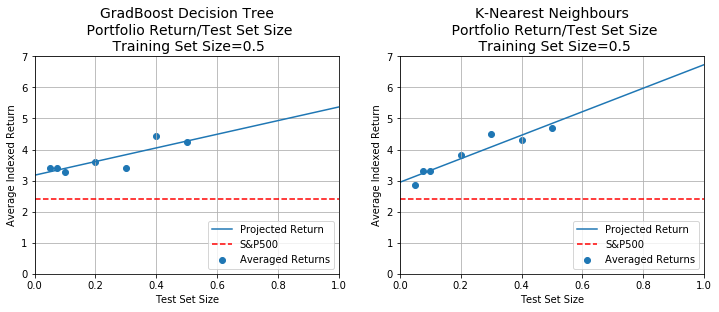

In [113]:
test_set_size = [0.5, 0.4, 0.3, 0.2, 0.1, 0.075, 0.05]
gradB_avgReturn = [4.23, 4.44, 3.39, 3.6, 3.29, 3.42, 3.42]
knn_avgReturn = [4.68, 4.32, 4.49, 3.83, 3.30, 3.31, 2.85]


plt.figure(figsize=(12,4))

linFit = LinearRegression().fit(np.array(test_set_size).reshape(-1,1), np.array(gradB_avgReturn).reshape(-1,1))
plt.subplot(1,2,1)
plt.scatter(test_set_size, gradB_avgReturn)
plt.xlim([0, 1])
plt.ylim([0, 7])
plt.title('GradBoost Decision Tree\n Portfolio Return/Test Set Size\n Training Set Size=0.5', fontsize=14)
plt.grid()
plt.ylabel('Average Indexed Return')
plt.xlabel('Test Set Size')
plt.plot([0,1], linFit.predict(np.array([0,1]).reshape(-1,1)),'-')
plt.plot([0,1],[2.4, 2.4],'r--')
plt.legend(['Projected Return','S&P500','Averaged Returns'],loc='lower right')


linFit = LinearRegression().fit(np.array(test_set_size).reshape(-1,1), np.array(knn_avgReturn).reshape(-1,1))
plt.subplot(1,2,2)
plt.scatter(test_set_size, knn_avgReturn)
plt.xlim([0, 1])
plt.ylim([0, 7])
plt.title('K-Nearest Neighbours\n Portfolio Return/Test Set Size\n Training Set Size=0.5', fontsize=14)
plt.grid()
plt.ylabel('Average Indexed Return')
plt.xlabel('Test Set Size')
plt.plot([0,1], linFit.predict(np.array([0,1]).reshape(-1,1)),'-')
plt.plot([0,1],[2.4, 2.4],'r--')
plt.legend(['Projected Return','S&P500','Averaged Returns'],loc='lower right')


# Final Stock Selection for 2020 with Gradient Boosted Decision Tree and K Nearest Neighbours

In [57]:
def pickStockForMe(model='GBoost'):
    '''
    Pick stocks.
    Reads Annual_Stock_Price_Fundamentals_Ratios.csv,
    and Annual_Stock_Price_Performance_Percentage.csv,
    trains the AI with the best model/parameters,
    Then picks stocks using outputs from Notebooks 1 and 2:
    Annual_Stock_Price_Fundamentals_Ratios_2021.csv,
    and Tickers_Dates_2021.csv.
    Outputs a DataFrame of best picks.
    '''
    # Training X and Y of all previous year data
    X=pd.read_csv("Annual_Stock_Price_Fundamentals_Ratios.csv", 
                  index_col=0)
    # annual stock performances
    yperf=pd.read_csv("Annual_Stock_Price_Performance_Percentage.csv", 
                      index_col=0)
    
    yperf=yperf["Perf"]

    # Stock selection ratios for 2021 X
    X_2021=pd.read_csv("Annual_Stock_Price_Fundamentals_Ratios_2021.csv"
                       , index_col=0)
    # And the row tickers
    tickers=pd.read_csv("Tickers_Dates_2021.csv", index_col=0)
    
    if model == 'GBoost':
        # Gradient Boosted tree
        model_pl = traingbregressorModel(X, yperf)
        y_pred=model_pl.predict(X_2021)
        y_pred=pd.DataFrame(y_pred)
    
    elif model == 'KNN':
        # KNN
        model_pl = trainKNeighborsModel(X, yperf)
        y_pred=model_pl.predict(X_2021)
        y_pred=pd.DataFrame(y_pred)
    
    else:
        return None

    # FINAL STOCK PICKS
    # Separate out stocks with low Z scores
    # 3.75 is approx. B- rating
    z = calcZScores(X_2021)
    zbl = (z['Z score'].reset_index(drop=True) > 2) 

    Final_Predictions = pd.DataFrame()
    Final_Predictions[['Ticker','Report Date']] = \
    tickers[['Ticker','Date']].reset_index(drop=True)\
                               [zbl].reset_index(drop=True)
    
    Final_Predictions['Perf. Score'] = y_pred.reset_index(drop=True)\
                                       [zbl].reset_index(drop=True)

    return Final_Predictions.sort_values(by='Perf. Score', 
                                         ascending=False)\
                                    .reset_index(drop=True).head(20)

In [60]:
# What it's all about.
pickStockForMe()

,Ticker,Report Date,Perf. Score
0,NWL,2021-02-19,3.563221
1,GLYC,2021-03-02,1.225311
2,KCAC,2021-02-23,1.057181
3,MAR,2021-02-18,0.983623
4,TRUP,2021-02-12,0.887129
5,BKD,2021-02-25,0.845757
6,AFI,2021-03-01,0.826474
7,CMLS,2021-02-23,0.825346
8,AWRE,2021-02-17,0.713920
9,YELP,2021-02-26,0.707375


In [61]:
pickStockForMe('KNN')

,Ticker,Report Date,Perf. Score
0,TBIO,2021-03-01,0.973940
1,AXL,2021-02-12,0.594791
2,SBGI,2021-03-01,0.571145
3,YELP,2021-02-26,0.467473
4,RCUS,2021-02-25,0.460436
5,EB,2021-03-01,0.447316
6,COMM,2021-02-17,0.422411
7,CMLS,2021-02-23,0.414910
8,CTMX,2021-02-24,0.412434
9,BGNE,2021-02-25,0.410689
